In [1]:
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc
import time
from IPython.display import Image

In [2]:
data = scipy.io.loadmat('./imagenet-vgg-verydeep-19.mat')

image_content = scipy.misc.imread('./images/hackathon.jpg')
image_content = image_content.astype('float32')
image_content = np.ndarray.reshape(image_content,((1,) + image_content.shape)) # 1 means batch_size

image_style = scipy.misc.imread('./images/style1.jpg')
image_style = image_style.astype('float32')
image_style = np.ndarray.reshape(image_style,((1,) + image_style.shape)) # 1 means batch_size

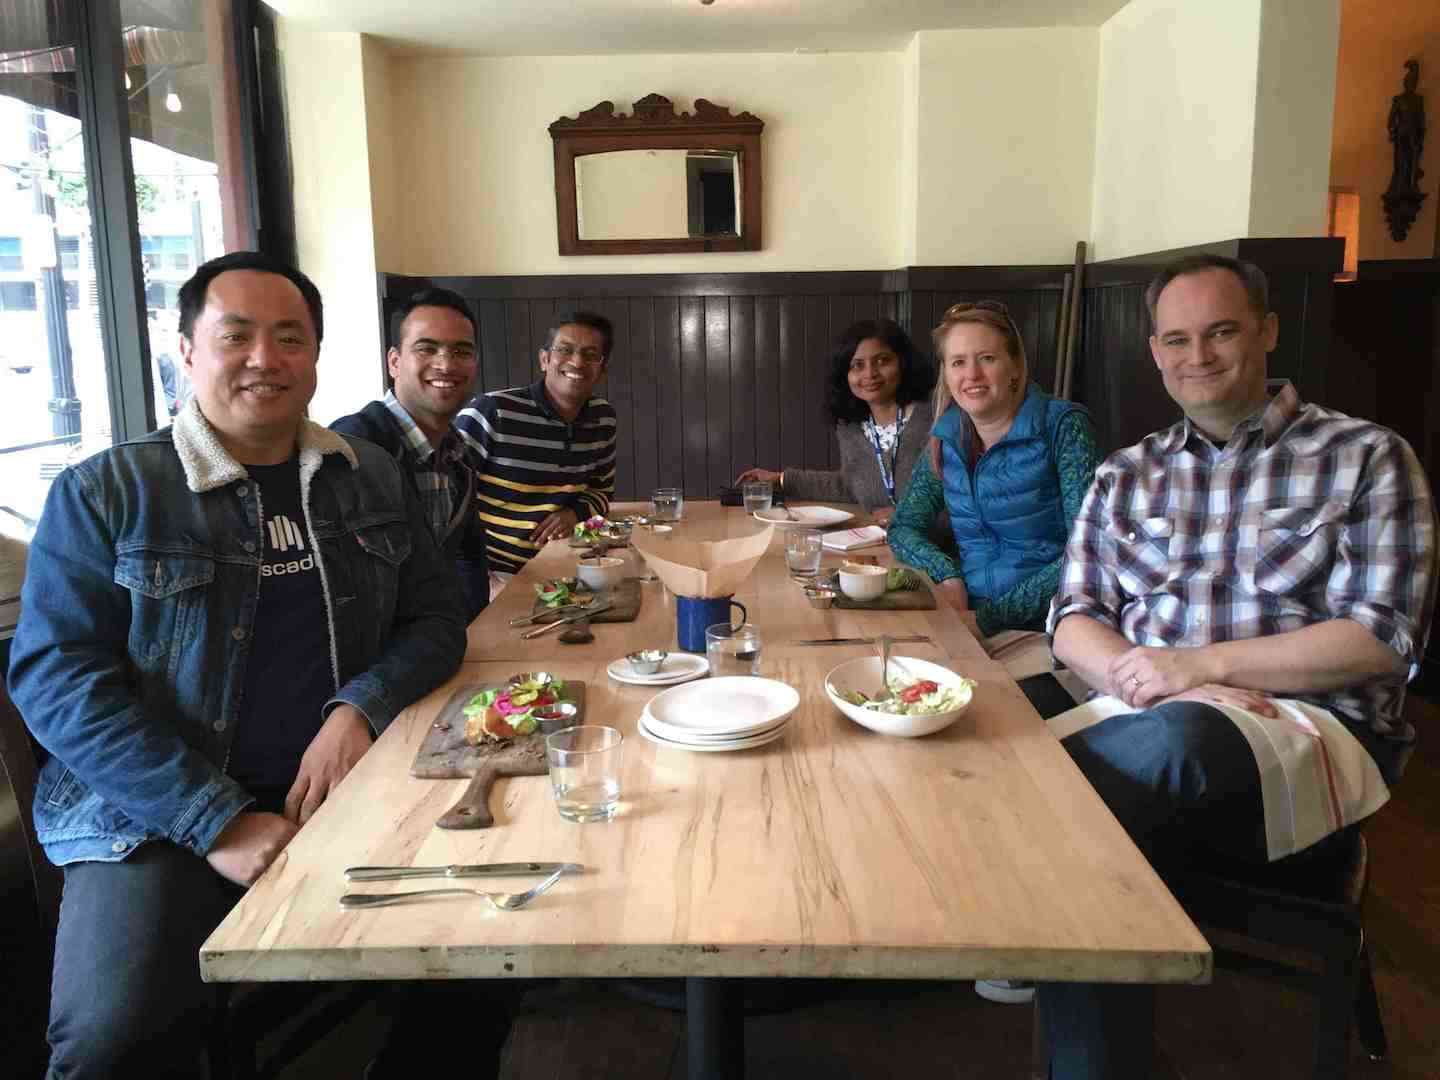

In [3]:
# content image
Image(filename = './images/hackathon.jpg')

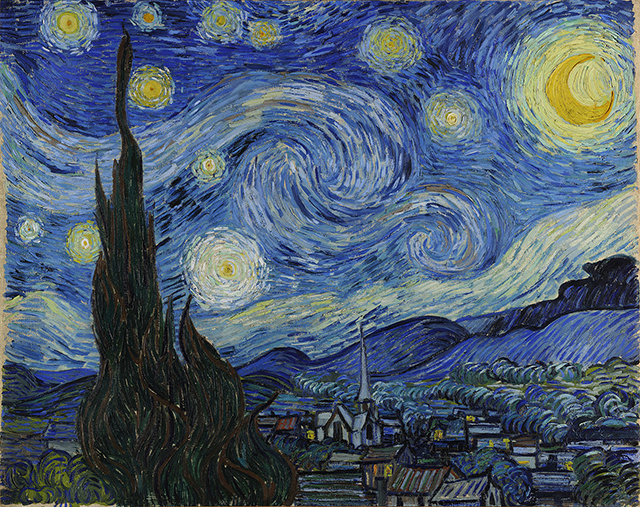

In [4]:
# style image
Image(filename = './images/style1.jpg')

In [5]:
def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)

def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

def preprocess(image, mean_pixel):
    return (image - mean_pixel).astype('float32')

def unprocess(image, mean_pixel):
    return (image + mean_pixel).astype('float32')

In [6]:
def net(weight, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weight[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current

    assert len(net) == len(layers)
    return net#, mean_pixel

In [7]:
mean = data['normalization'][0][0][0]
mean_pixel = np.mean(mean, axis=(0, 1))

In [8]:
CONTENT_LAYER = 'relu4_2'
content_features = {}

with tf.Session() as sess:
    content_pre = preprocess(image_content, mean_pixel)
    content_net = net(np.squeeze(data['layers']), content_pre)
    content_features[CONTENT_LAYER] = content_net[CONTENT_LAYER].eval()

In [9]:
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')
style_features = {}

with tf.Session() as sess:
    style_pre = preprocess(image_style, mean_pixel)
    style_net = net(np.squeeze(data['layers']), style_pre)
    for layer in STYLE_LAYERS:
        features = style_net[layer].eval()
        features = np.reshape(features, (-1, features.shape[3]))
        gram = np.matmul(features.T, features) / features.size
        style_features[layer] = gram

In [10]:
# make stylized image using backpropogation
initial = None
if initial is None:
    noise = np.random.normal(size=image_content.shape, scale=np.std(image_content) * 0.1)
    initial = tf.random_normal(image_content.shape) * 0.256
else:
    initial = np.array([preprocess(initial, mean_pixel)])
    initial = initial.astype('float32')

In [11]:
image = tf.Variable(initial)
image_net = net(np.squeeze(data['layers']), image)

In [12]:
content_weight = 5e0
style_weight = 1.1e2 
tv_weight = 1e2
learning_rate = 1e1
iterations = 1000
checkpoint_iterations = 10
print_iterations = 50

In [13]:
# content loss
content_loss = content_weight * (2 * tf.nn.l2_loss(
        image_net[CONTENT_LAYER] - content_features[CONTENT_LAYER]) / 
        content_features[CONTENT_LAYER].size)

In [14]:
# style loss
style_loss = 0
style_losses = []
for style_layer in STYLE_LAYERS:
    layer = image_net[style_layer]
    _, height, width, number = map(lambda i: i.value, layer.get_shape())
    size = height * width * number
    feats = tf.reshape(layer, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats) / size
    style_gram = style_features[style_layer]
    style_losses.append(2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
style_loss += style_weight * reduce(tf.add, style_losses)

In [15]:
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

In [16]:
# total variation denoising
tv_y_size = _tensor_size(image[:,1:,:,:])
tv_x_size = _tensor_size(image[:,:,1:,:])
tv_loss = tv_weight * 2 * (
        (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:image_content.shape[1]-1,:,:]) /
            tv_y_size) +
        (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:image_content.shape[2]-1,:]) /
            tv_x_size))

In [17]:
# overall loss
loss = content_loss + style_loss + tv_loss

In [18]:
# optimizer setup
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [19]:
# optimization
best_loss = float('inf')
best = None

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(iterations):
        train_step.run()
        
        if i % checkpoint_iterations == 0 or i == iterations - 1:
            this_loss = loss.eval()
            if this_loss < best_loss:
                best_loss = this_loss
                best = image.eval()
            # save a check point
            timestr = time.strftime("%Y%m%d_%H%M%S")
            filename_cp = './checks/hackathon/'+timestr+'.jpg'
            cp = unprocess(best.reshape(image_content.shape[1:]), mean_pixel)
            scipy.misc.imsave(filename_cp, cp)
        
        if i % print_iterations == 0 or i == iterations - 1:
            print('Iteration %d/%d' % (i + 1, iterations))
            print('  content loss: %g' % content_loss.eval())
            print('    style loss: %g' % style_loss.eval())
            print('       tv loss: %g' % tv_loss.eval())
            print('    total loss: %g' % loss.eval())

    output = unprocess(best.reshape(image_content.shape[1:]), mean_pixel)

Iteration 1/1000
  content loss: 1.44898e+06
    style loss: 8.29856e+07
       tv loss: 23433.6
    total loss: 8.44581e+07
Iteration 51/1000
  content loss: 1.87356e+06
    style loss: 492484
       tv loss: 184970
    total loss: 2.55102e+06
Iteration 101/1000
  content loss: 1.36492e+06
    style loss: 252830
       tv loss: 144483
    total loss: 1.76224e+06
Iteration 151/1000
  content loss: 1.21325e+06
    style loss: 219602
       tv loss: 125599
    total loss: 1.55845e+06
Iteration 201/1000
  content loss: 1.09013e+06
    style loss: 264453
       tv loss: 112606
    total loss: 1.46719e+06
Iteration 251/1000
  content loss: 1.07156e+06
    style loss: 278576
       tv loss: 105494
    total loss: 1.45563e+06
Iteration 301/1000
  content loss: 1.03745e+06
    style loss: 205499
       tv loss: 100361
    total loss: 1.34330e+06
Iteration 351/1000
  content loss: 1.00817e+06
    style loss: 218298
       tv loss: 96153.9
    total loss: 1.32262e+06
Iteration 401/1000
  content

In [20]:
scipy.misc.imsave('./images/output_hackathon.jpg', output)

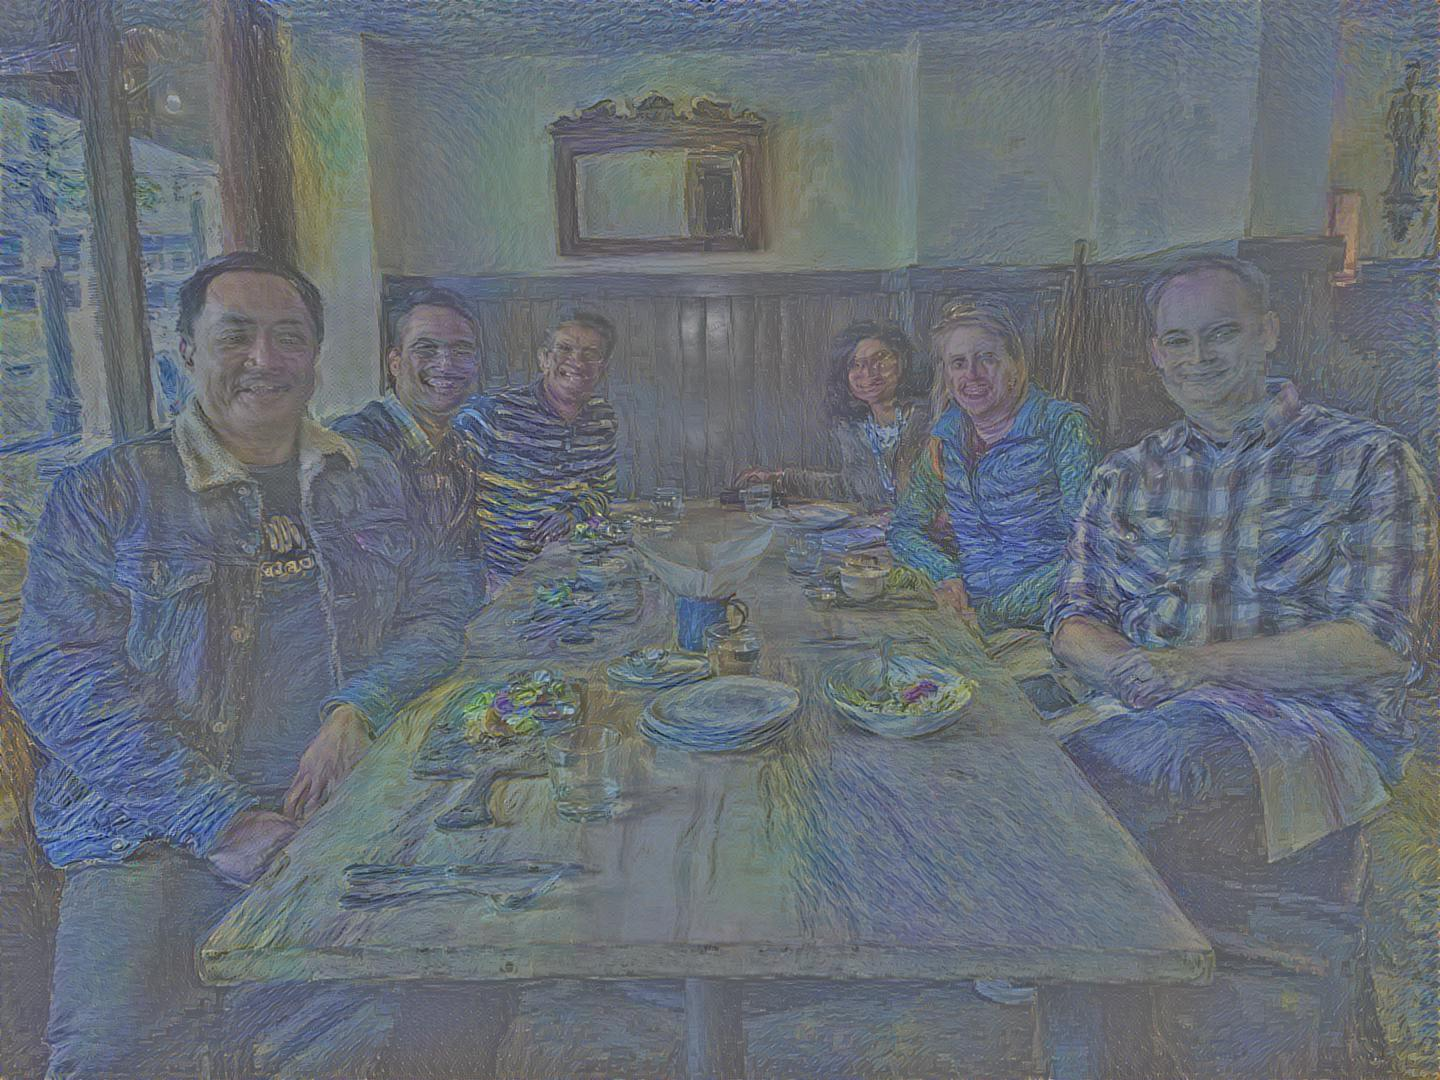

In [21]:
Image(filename = './images/output_hackathon.jpg')